In [2]:
from keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow import keras

In [3]:
base_model = keras.applications.VGG19(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(50, 50, 3),
    include_top=False)  # Do not include the ImageNet classifier at the top.

2022-04-14 10:16:24.088483: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        #self.beta_coefficient = beta_coefficient
    
    def call(self, inputs):
        x = self.encoder(inputs)[2]
        return self.decoder(x)
    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_sum(
                    keras.losses.MSE(data, reconstruction), axis=(1, 2) # mod
                )
           # )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [5]:

vae_encoder = load_model('models/vae_encoder.h5')
vae_decoder = load_model('models/vae_decoder.h5')
vae = VAE(encoder=vae_encoder, decoder=vae_decoder)
vae(np.zeros((1,50,50,3)))
vae.load_weights('weights/vae.h5')
model = vae_decoder

In [6]:
import cv2

test = cv2.imread('datasets/breast-histopathology/IDC_regular_ps50_idx5/13689/1/13689_idx5_x801_y1501_class1.png', cv2.IMREAD_COLOR)

In [7]:
test = test / 255
test.shape

(50, 50, 3)

In [8]:
# We preprocess the image into a 4D tensor
from keras.preprocessing import image
import numpy as np

img = cv2.imread('datasets/breast-histopathology/IDC_regular_ps50_idx5/13689/1/13689_idx5_x801_y1501_class1.png', cv2.IMREAD_COLOR)
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
# Remember that the model was trained on inputs
# that were preprocessed in the following way:
img_tensor /= 255.

# Its shape is (1, 150, 150, 3)
print(img_tensor.shape)

(1, 50, 50, 3)


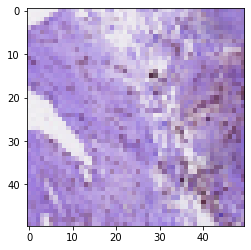

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(img_tensor[0])
plt.show()

In [10]:
from keras import models

# Extracts the outputs of the top 8 layers:
import tensorflow as tf

layer_outputs = []
layer_names = []
for layer in model.layers[1:]:
    
    try: 
        layer_outputs.append(layer.get_output_at(1))
        layer_names.append(layer.name)
    
    except:
        layer_outputs.append(layer.output)
        layer_names.append(layer.name)

# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)
activation_model

In [11]:
layer_names

['reshape_2',
 'up_block4_conv1',
 'up_block4_conv2',
 'up_block5_conv1',
 'up_block5_conv2',
 'up_sampling2d_5',
 'up_block6_conv1',
 'conv2d_transpose_5']

In [31]:
model.get_layer('up_block6_conv1')

In [32]:
model.get_layer('up_block6_conv1')

In [36]:
# This will return a list of 5 Numpy arrays:
# one array per layer activation
activations = activation_model.predict(vae_encoder(img_tensor)[2])
activations

[array([[[[-9.4201893e-01, -2.9289222e-01,  1.0171007e+00],
          [ 5.7068658e-01,  5.3808117e-01,  7.8892432e-02],
          [-2.3822856e+00, -2.8016561e-01,  2.6665189e+00],
          ...,
          [ 1.0086026e-01, -1.6754102e+00, -1.7962203e+00],
          [ 1.4263548e+00, -2.5462496e-01, -2.9211529e-02],
          [-2.8210294e-01,  4.2800933e-01, -4.4824135e-02]],
 
         [[ 4.0308166e-01,  5.2109897e-01,  9.4999582e-01],
          [-3.8991493e-01, -1.0559210e+00,  5.2713186e-02],
          [-8.3344132e-01, -2.4279541e-01, -1.8569124e+00],
          ...,
          [-1.0986704e-01, -1.6011963e+00,  6.2942922e-01],
          [-2.2246364e-01, -4.5762151e-01,  8.2005449e-02],
          [ 4.5352176e-01,  9.3316483e-01, -3.1630555e-01]],
 
         [[ 1.2950941e+00,  4.6000141e-01,  1.6784186e+00],
          [ 2.2883710e-01,  1.7496706e+00, -1.2074448e+00],
          [ 3.0543488e-01, -1.3111459e-01,  1.5470234e+00],
          ...,
          [ 1.0232563e+00,  1.0857314e-02, -5.933

In [34]:
print(len(activations))
print(len(layer_names))

8
8


In [37]:
first_layer_activation = activations[6]
print(first_layer_activation.shape)
first_layer_activation.shape[3]

(1, 50, 50, 64)


64

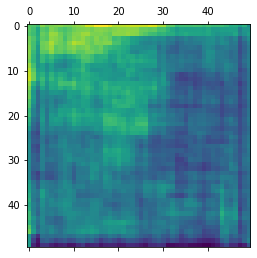

In [38]:
import matplotlib.pyplot as plt

plt.matshow(first_layer_activation[0, :, :, 1], cmap='viridis')
plt.show()

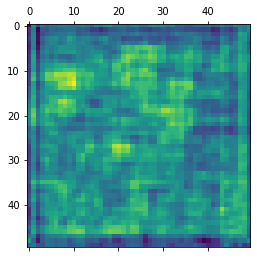

In [47]:
plt.matshow(first_layer_activation[0,:, :, 63], cmap='viridis')
plt.show()

In [40]:
activ = first_layer_activation[0,:, :, 5]

In [41]:
f_min, f_max = activ.min(), activ.max()
filters = (activ - f_min) / (f_max - f_min) 
filters.max()

In [43]:
activation_layer = first_layer_activation
n = math.floor(np.sqrt(first_layer_activation.shape[3]))
int(n + 0.5) ** 2 

64

In [44]:
m = n

In [45]:
filter_counter = 0
for i in range(n):
    for j in range(m):
     

       # ax[i, j].imshow(activation_layer[0,:, :, filter_counter], cmap='viridis')
        filter_counter += 1
        print(i)
        print(j)
        print(filter_counter)

0
0
1
0
1
2
0
2
3
0
3
4
0
4
5
0
5
6
0
6
7
0
7
8
1
0
9
1
1
10
1
2
11
1
3
12
1
4
13
1
5
14
1
6
15
1
7
16
2
0
17
2
1
18
2
2
19
2
3
20
2
4
21
2
5
22
2
6
23
2
7
24
3
0
25
3
1
26
3
2
27
3
3
28
3
4
29
3
5
30
3
6
31
3
7
32
4
0
33
4
1
34
4
2
35
4
3
36
4
4
37
4
5
38
4
6
39
4
7
40
5
0
41
5
1
42
5
2
43
5
3
44
5
4
45
5
5
46
5
6
47
5
7
48
6
0
49
6
1
50
6
2
51
6
3
52
6
4
53
6
5
54
6
6
55
6
7
56
7
0
57
7
1
58
7
2
59
7
3
60
7
4
61
7
5
62
7
6
63
7
7
64


In [50]:
 (activation_layer.shape[3] - 1)

63

In [71]:
import math
def plot_filters(activation_layer, layer_name, counter):

    n = math.floor(np.sqrt(activation_layer.shape[3]))

    if int(n + 0.5) ** 2 == activation_layer.shape[3]:

        m = n
    else:
        m = math.floor(activation_layer.shape[3] / n)

    
    if n == 1:
        fig, ax = plt.subplots(1, 3, sharex='col', sharey='row',figsize=(15, 15))
        fig.suptitle(layer_name)
        for i in range(3):
            ax[i].imshow(activation_layer[0,:, :, i], cmap='viridis')
        fig.savefig('img/activations/vae/{}_activations_{}.png'.format(counter, layer_name))
        return None   

    fig, ax = plt.subplots(n, m, sharex='col', sharey='row',figsize=(15, 15))
    fig.suptitle(layer_name)
    
 

    filter_counter = 0
    for i in range(n):
        for j in range(m):
            ax[i, j].imshow(activation_layer[0,:, :, filter_counter], cmap='viridis')
            filter_counter += 1
            if filter_counter == (activation_layer.shape[3] ):
                break
    
    fig.savefig('img/activations/vae/{}_activations_{}.png'.format(counter, layer_name))
    return None

In [26]:
for activation, name in zip(activations[1:], layer_names[1:]):
    print(name)
    print(activation.shape)
    

up_block4_conv1
(1, 25, 25, 16)
up_block4_conv2
(1, 25, 25, 16)
up_block5_conv1
(1, 25, 25, 32)
up_block5_conv2
(1, 25, 25, 32)
up_sampling2d_5
(1, 50, 50, 32)
up_block6_conv1
(1, 50, 50, 64)
conv2d_transpose_5
(1, 50, 50, 3)


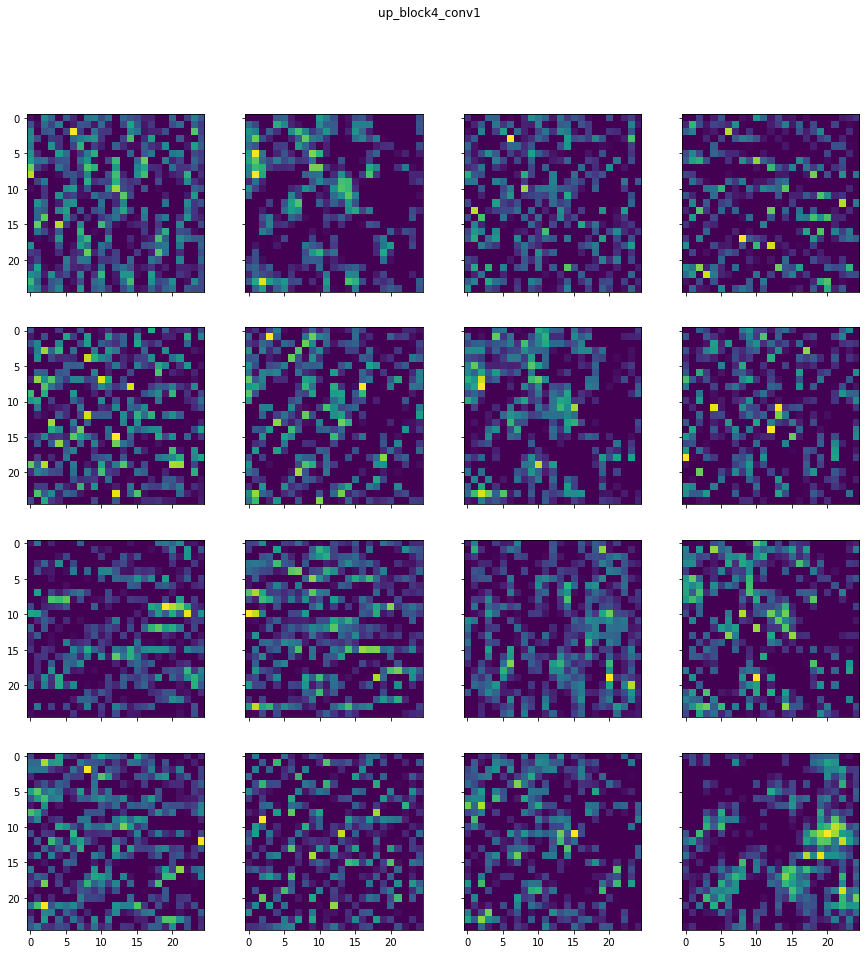

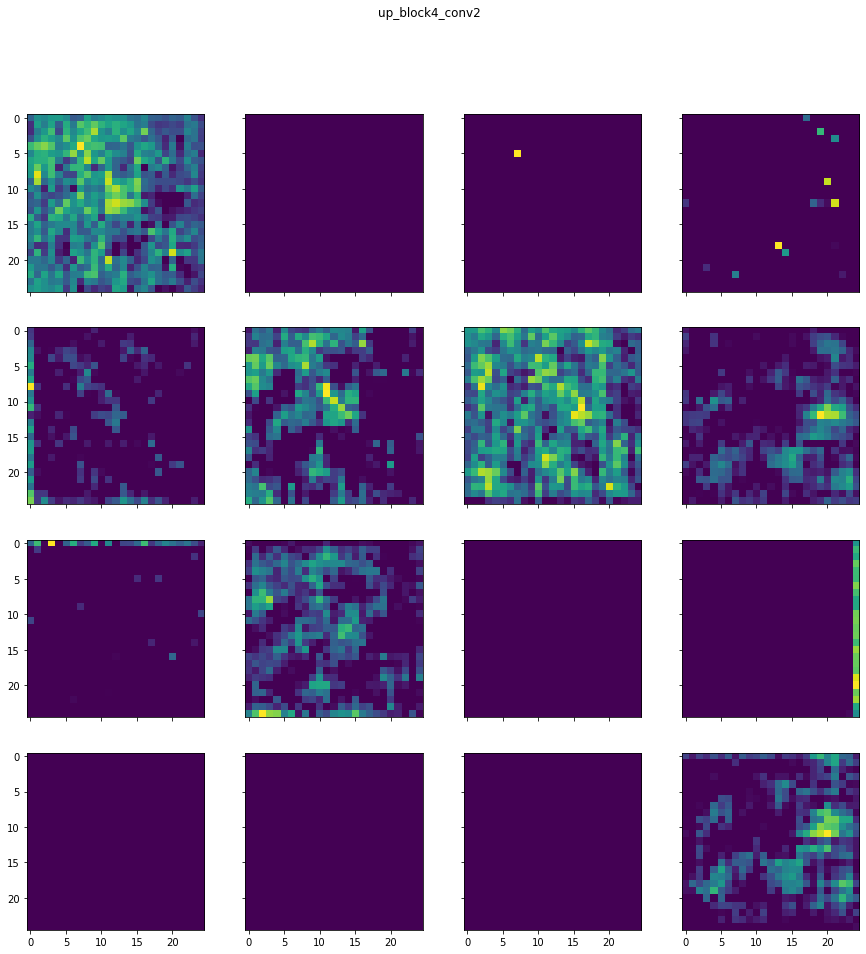

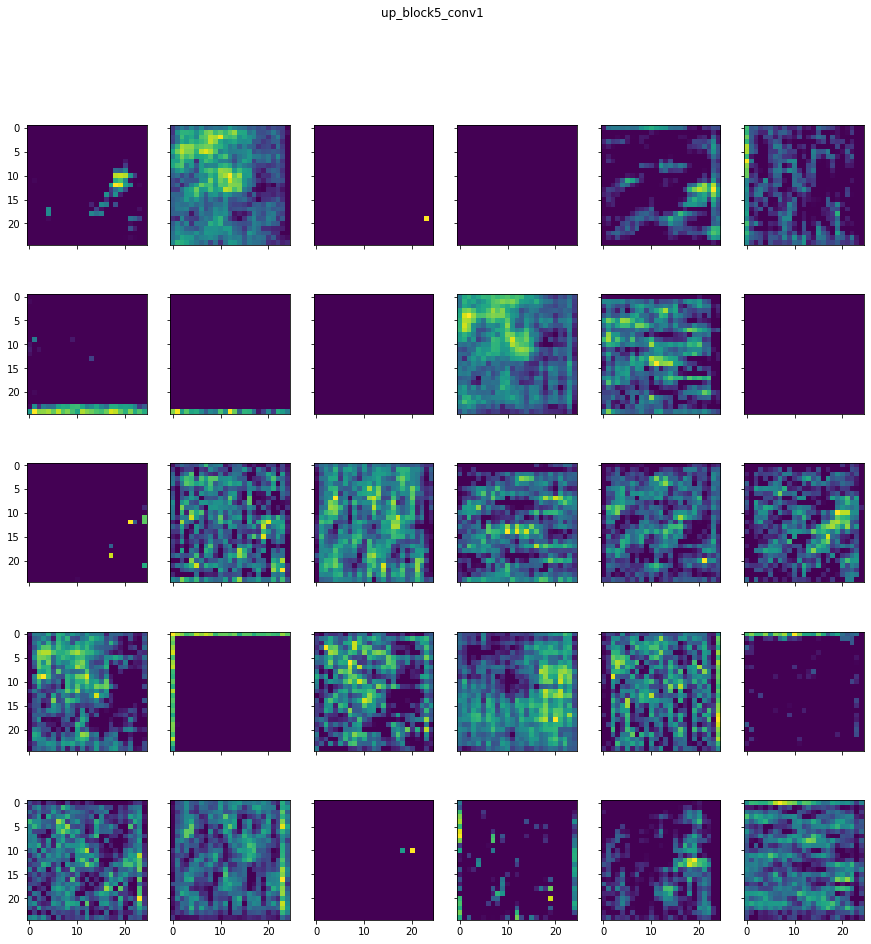

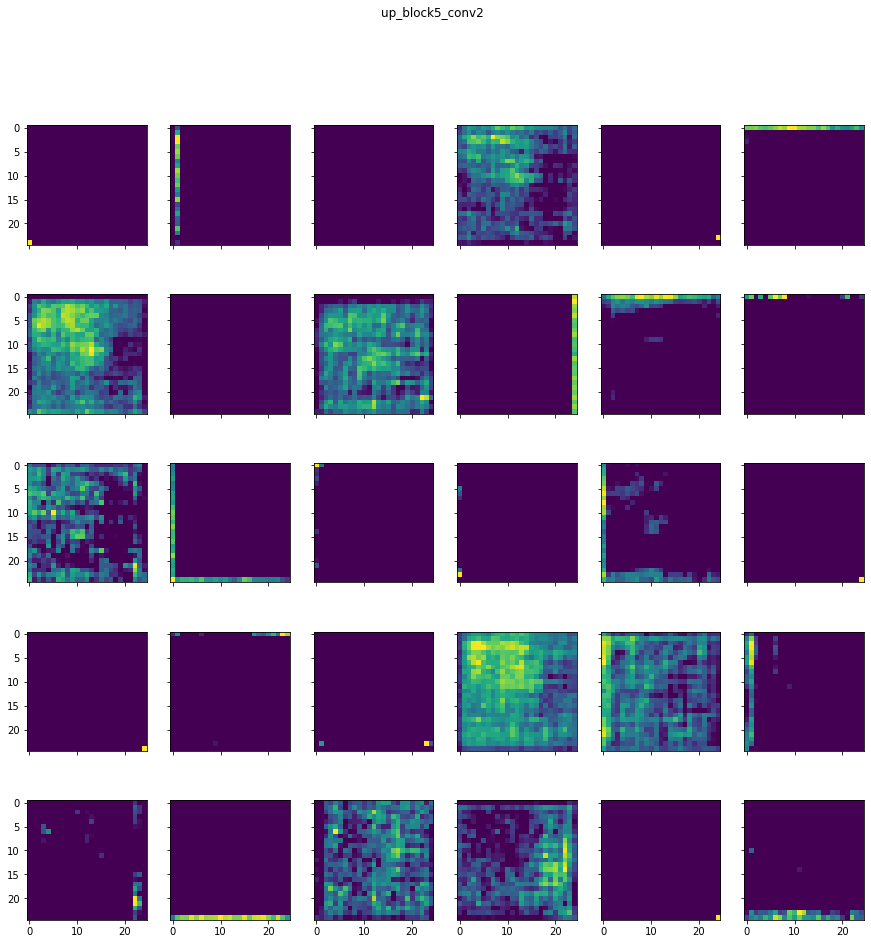

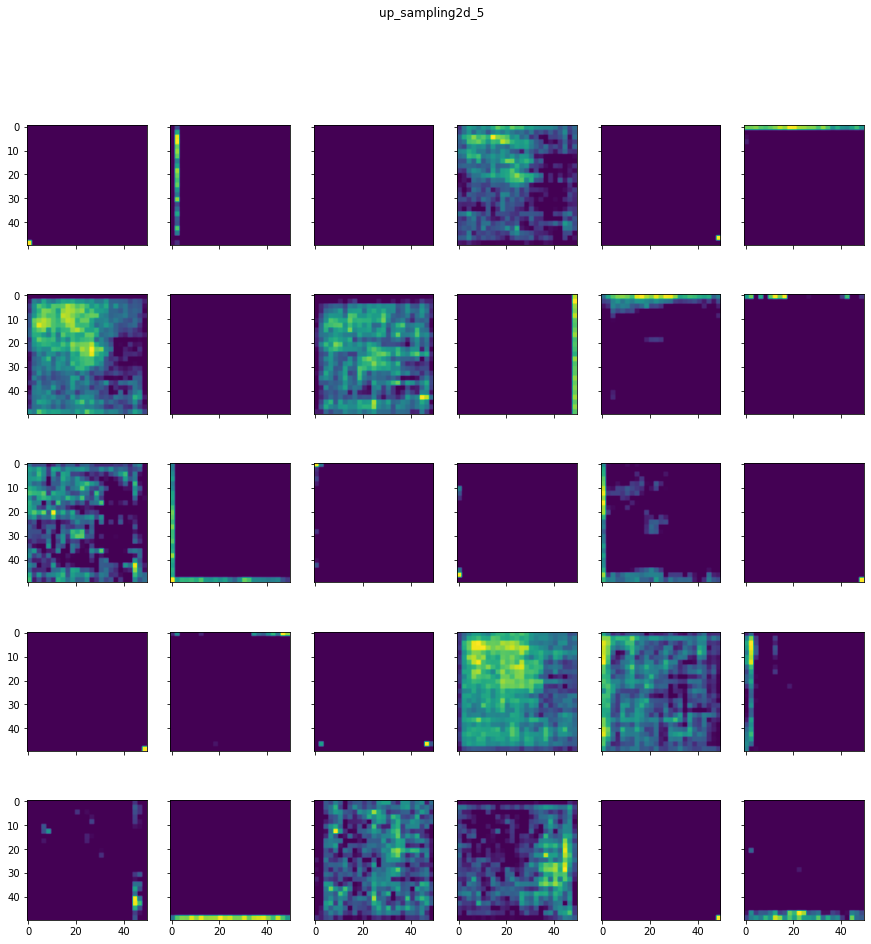

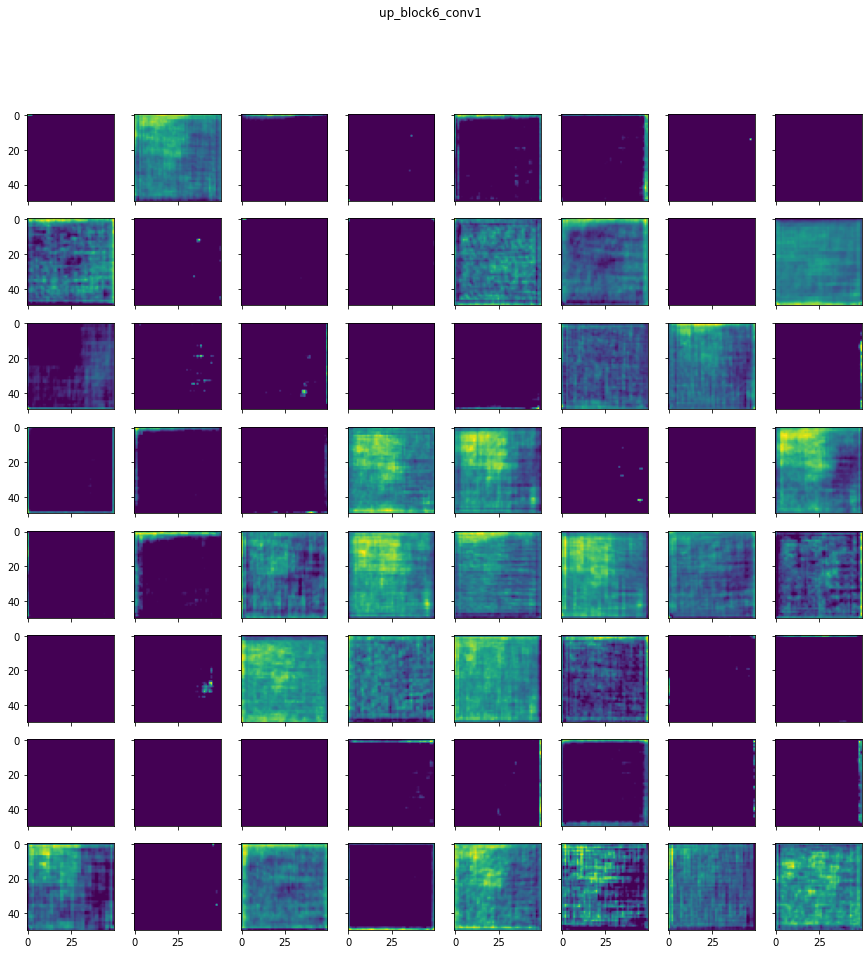

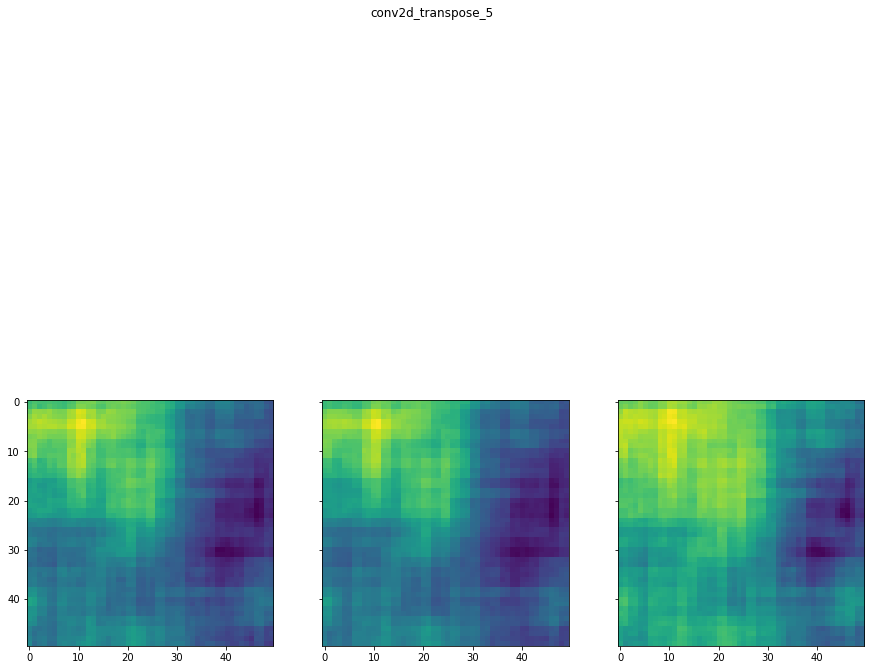

In [72]:
for counter, (activation, name) in enumerate(zip(activations[1:], layer_names[1:])):

    plot_filters(activation, name, counter)

AttributeError: 'Model' object has no attribute 'add'

In [ ]:
for layer in net.layers:
    print(layer.name)

NameError: name 'net' is not defined

In [ ]:
net.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 50, 50, 3)]       0         
                                                                 
 sequential_14 (Sequential)  (None, 25, 25, 2)         56        
                                                                 
 dense_6 (Dense)             (None, 25, 25, 2)         6         
                                                                 
Total params: 62
Trainable params: 62
Non-trainable params: 0
_________________________________________________________________


In [ ]:
net.get_layer('sequential_14')